In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=cpu,floatX=float32,optimizer=fast_compile'

In [2]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import theano.tensor as T
import tensorflow as tf
import tensorflow.keras.models as models
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import cv2
import numpy as np

path = './CamVid/'
data_shape = 360*480

In [3]:
def normalized(rgb):
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)
    b=rgb[:,:,0]
    g=rgb[:,:,1]
    r=rgb[:,:,2]
    norm[:,:,0]=cv2.equalizeHist(b)
    norm[:,:,1]=cv2.equalizeHist(g)
    norm[:,:,2]=cv2.equalizeHist(r)
    return norm
def binarylab(labels):
    x = np.zeros([360,480,12])    
    for i in range(360):
        for j in range(480):
            x[i,j,labels[i][j]]=1
    return x
def prep_data():
    train_data = []
    train_label = []
    import os
    with open(path+'train.txt') as f:
        txt = f.readlines()
        txt = [line.split(' ') for line in txt]
    for i in range(len(txt)):
        train_data.append(np.rollaxis(normalized(cv2.imread(os.getcwd() + txt[i][0][7:])),2))
        train_label.append(binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0]))
        print('.',end='')
    return np.array(train_data), np.array(train_label)

train_data, train_label = prep_data()
train_label = np.reshape(train_label,(367,data_shape,12))

...............................................................................................................................................................................................................................................................................................................................................................................

In [4]:
class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.9051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]

In [5]:
class UnPooling2D(Layer):
    def __init__(self, poolsize=(2, 2)):
        super(UnPooling2D, self).__init__()
        self.Input = T.tensor4()
        self.poolsize = poolsize
    @property
    def output_shape(self):
        input_shape = self.input_shape
        return (input_shape[0], input_shape[1],
                self.poolsize[0] * input_shape[2],
                self.poolsize[1] * input_shape[3])
    def get_output(self, train):
        X = self.get_input(train)
        s1 = self.poolsize[0]
        s2 = self.poolsize[1]
        output = X.repeat(s1, axis=2).repeat(s2, axis=3)
        return output
    def get_config(self):
        return {"name":self.__class__.__name__,
            "poolsize":self.poolsize}

In [6]:
def create_encoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return [
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(filter_size, kernel, kernel, padding='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size),data_format="channels_first"),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, padding='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size),data_format="channels_first"),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, padding='valid'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size),data_format="channels_first"),

        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(512, kernel, kernel, padding='valid'),
        BatchNormalization(),
        Activation('relu'),
    ]
def create_decoding_layers():
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    return[
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(512, kernel, kernel, padding='valid'),
        BatchNormalization(),

        UnPooling2D(poolsize=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(256, kernel, kernel, padding='valid'),
        BatchNormalization(),

        UnPooling2D(poolsize=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(128, kernel, kernel, padding='valid'),
        BatchNormalization(),

        UnPooling2D(poolsize=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Convolution2D(filter_size, kernel, kernel, padding='valid'),
        BatchNormalization(),
    ]


autoencoder = models.Sequential()

autoencoder.add(Layer(input_shape=(3,360,480)))

autoencoder.encoding_layers = create_encoding_layers()
autoencoder.decoding_layers = create_decoding_layers()

for l in autoencoder.encoding_layers:
    autoencoder.add(l)
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

autoencoder.add(Convolution2D(12, 1, 1, padding='valid',))
autoencoder.add(Reshape((12,data_shape)))
autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('softmax'))
autoencoder.compile(loss="categorical_crossentropy", optimizer='adadelta', metrics=['accuracy'])

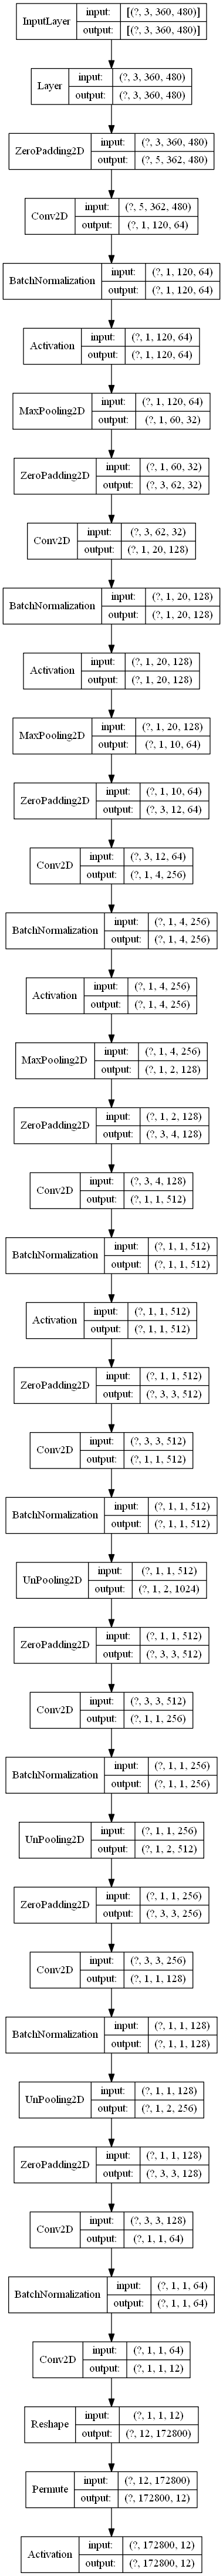

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [8]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Layer)                (None, 3, 360, 480)       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 5, 362, 480)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 120, 64)        276544    
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 120, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 1, 120, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 60, 32)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 62, 32)         0

In [9]:
nb_epoch = 10
batch_size = 10
history = history = autoencoder.fit(train_data, train_label, batch_size=batch_size, epochs=nb_epoch, verbose=1, class_weight=class_weighting )
autoencoder.save_weights('model_weight_ep100.hdf5')
#score = autoencoder.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1])

Train on 367 samples
Epoch 1/10
 10/367 [..............................] - ETA: 8:05

AbortedError:  Compute received an exception:Status: 3, message: could not init a forward pooling descriptor, in file tensorflow/core/kernels/mkl_maxpooling_op.cc:201
	 [[node sequential/max_pooling2d/MaxPool (defined at C:\Users\arik0\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_distributed_function_3788]

Function call stack:
distributed_function
